In [ ]:
# Jovian Commit Essentials
!pip install jovian --upgrade -q
import jovian
jovian.set_project('deep-learning-project')
jovian.set_colab_id('1IOCS7kFUVduHPGf4IFG8C_EUHOZgVzta')

     |████████████████████████████████| 68 kB 4.5 MB/s 


# Malaria Cell Deep Learning Model

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="deep-learning-project")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/braydonwang/deep-learning-project


'https://jovian.ai/braydonwang/deep-learning-project'

# Identifying Malaria Cells using Deep Learning and PyTorch

1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Prepare the dataset for training
5. Move the dataset to the GPU
6. Define a neural networks
7. Train the model
8. Make predictions on sample images, iterate on it with different networks & hyperparameters


### Download the Dataset

Using 'opendatasets' and download https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria .

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria'

In [ ]:
import os
import shutil

if os.path.exists('./cell-images-for-detecting-malaria'): 
  shutil.rmtree('./cell-images-for-detecting-malaria')

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: braydonwang
Your Kaggle Key: ··········


100%|██████████| 675M/675M [00:04<00:00, 146MB/s]


In [ ]:
data_dir = './cell-images-for-detecting-malaria/cell_images'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['Parasitized', 'Uninfected', 'cell_images']

In [ ]:
import shutil

shutil.rmtree(data_dir + '/cell_images')

In [ ]:
os.listdir(data_dir)

['Parasitized', 'Uninfected']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':',  len(os.listdir(data_dir + '/' + cls)))

Parasitized : 13780
Uninfected : 13780


### Import the Dataset Into PyTorch

Use the 'ImageFolder' class from 'torchvision'.

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

27558

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=142x148 at 0x7FE9E5217990>, 0)

In [ ]:
dataset.classes

['Parasitized', 'Uninfected']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

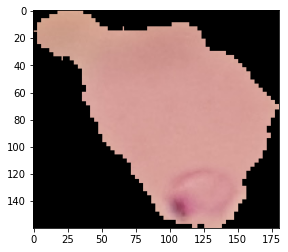

In [ ]:
img, label = dataset[100]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

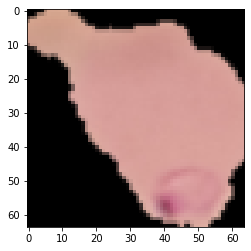

In [ ]:
img, label = dataset[100]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(24803, 2755)

In [ ]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(24803, 2755)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


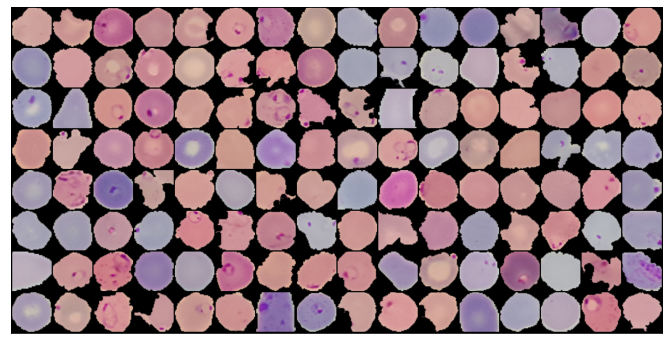

In [ ]:
show_batch(train_dl)

## GPU Utilities

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for batch of data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 2 x 2
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [ ]:
jovian.commit(project='deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/braydonwang/deep-learning-project


'https://jovian.ai/braydonwang/deep-learning-project'

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 2])


### Training

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.48780953884124756, 'val_loss': 0.6936571002006531}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.4249, val_loss: 0.1520, val_acc: 0.9437
Epoch [1], train_loss: 0.1657, val_loss: 0.1536, val_acc: 0.9465
Epoch [2], train_loss: 0.1505, val_loss: 0.1463, val_acc: 0.9529
Epoch [3], train_loss: 0.1440, val_loss: 0.1361, val_acc: 0.9536
Epoch [4], train_loss: 0.1345, val_loss: 0.1356, val_acc: 0.9515


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.1184, val_loss: 0.1204, val_acc: 0.9564
Epoch [1], train_loss: 0.1101, val_loss: 0.1196, val_acc: 0.9536
Epoch [2], train_loss: 0.1083, val_loss: 0.1057, val_acc: 0.9589
Epoch [3], train_loss: 0.1009, val_loss: 0.1130, val_acc: 0.9592
Epoch [4], train_loss: 0.1011, val_loss: 0.1195, val_acc: 0.9550


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

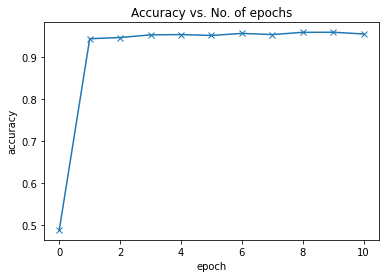

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

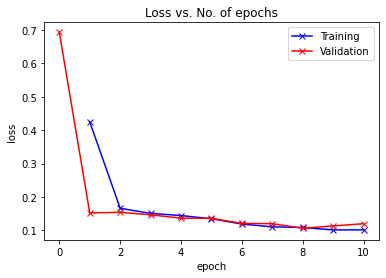

In [ ]:
plot_losses(history)

## Record the Results

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128, 
                       arch='ResNet9', 
                       epochs=[5, 5],
                       lrs=[0.001,1e-4],
                       opt=['Adam','Adam'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [ ]:
jovian.commit(project='deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/braydonwang/deep-learning-project


'https://jovian.ai/braydonwang/deep-learning-project'

## Test with Individual Images

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
  plt.imshow(img.permute((1,2,0)))
  pred = predict_image(img, model, dataset.classes)
  print('Target:', dataset.classes[label])
  print('Prediction:', pred)

Target: Uninfected
Prediction: Uninfected


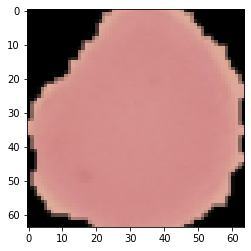

In [ ]:
show_image_prediction(*valid_ds[90])

Target: Parasitized
Prediction: Parasitized


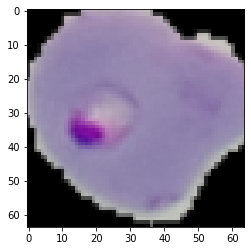

In [ ]:
show_image_prediction(*valid_ds[243])

Target: Uninfected
Prediction: Uninfected


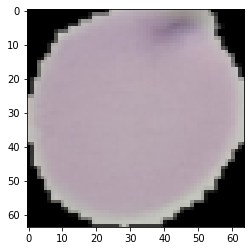

In [ ]:
show_image_prediction(*valid_ds[378])

Target: Parasitized
Prediction: Parasitized


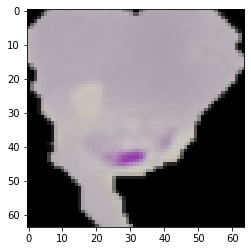

In [ ]:
show_image_prediction(*valid_ds[12])

In [ ]:
torch.save(model.state_dict(), 'malaria-cell-resnet9.pth')

In [ ]:
jovian.commit(project='deep-learning-project',
              outputs=['malaria-cell-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/braydonwang/deep-learning-project


'https://jovian.ai/braydonwang/deep-learning-project'